# Had to clear all output for file size reasons.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from other_utils import pca_tsne_mols
import plotly.express as px

# shut off warnings
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')  

import matplotlib
from matplotlib import rc
font = {'size'   : 8}
matplotlib.rc('font', **font)

# change font
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Part 1: Read in and process all possible datasets for comparisons

In [3]:
# take in dilution-regrowth and inhibition dataframe 
# note that this is only the primary screen, not ML-guided screen
df = pd.read_excel('../data/TrainingDataRound1_wValidation.xlsx')
df = df[[type(x) != float for x in list(df['SMILES'])]]
print('num drh drugs: ' + str(len(df)))
df = df[['SMILES', 'Name']]

# convert SMILES to fingerprints
drh_smiles = list(df['SMILES'])
drh_mols = [Chem.MolFromSmiles(x) for x in drh_smiles]
drh_fps, drh_names = zip(*[(Chem.RDKFingerprint(x),y) for x,y in zip(drh_mols,list(df['Name'])) if x is not None])

# get fingerprints for abx
abx = pd.read_csv('../data/curated_set_of_566_abx.csv')
abx = abx[[type(x) != float for x in list(abx['Smiles'])]]
abx_smiles = list(abx['Smiles'])
mols = [Chem.MolFromSmiles(x) for x in abx_smiles]
abx_fps, abx_names, abx_classes = zip(*[(Chem.RDKFingerprint(x),y,z) for x,y,z in zip(mols,list(abx['Name']),list(abx['Class-Annotated'])) if x is not None])

# read in all broad800K - takes a while due to all 800K
broad = pd.read_csv('../data/broad800k.csv') # the clean one of just smiles

# get random sample
broad = broad.sample(n=50000)

# get fingerprints for broad800K sample
broad_smiles = list(broad['smiles'])
broad_mols = [Chem.MolFromSmiles(x) for x in broad_smiles]
broad_fps = [Chem.RDKFingerprint(x) for x in broad_mols if x is not None]

num drh drugs: 6711


variance explained by pc1+pc2: 0.1346488745600286


/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


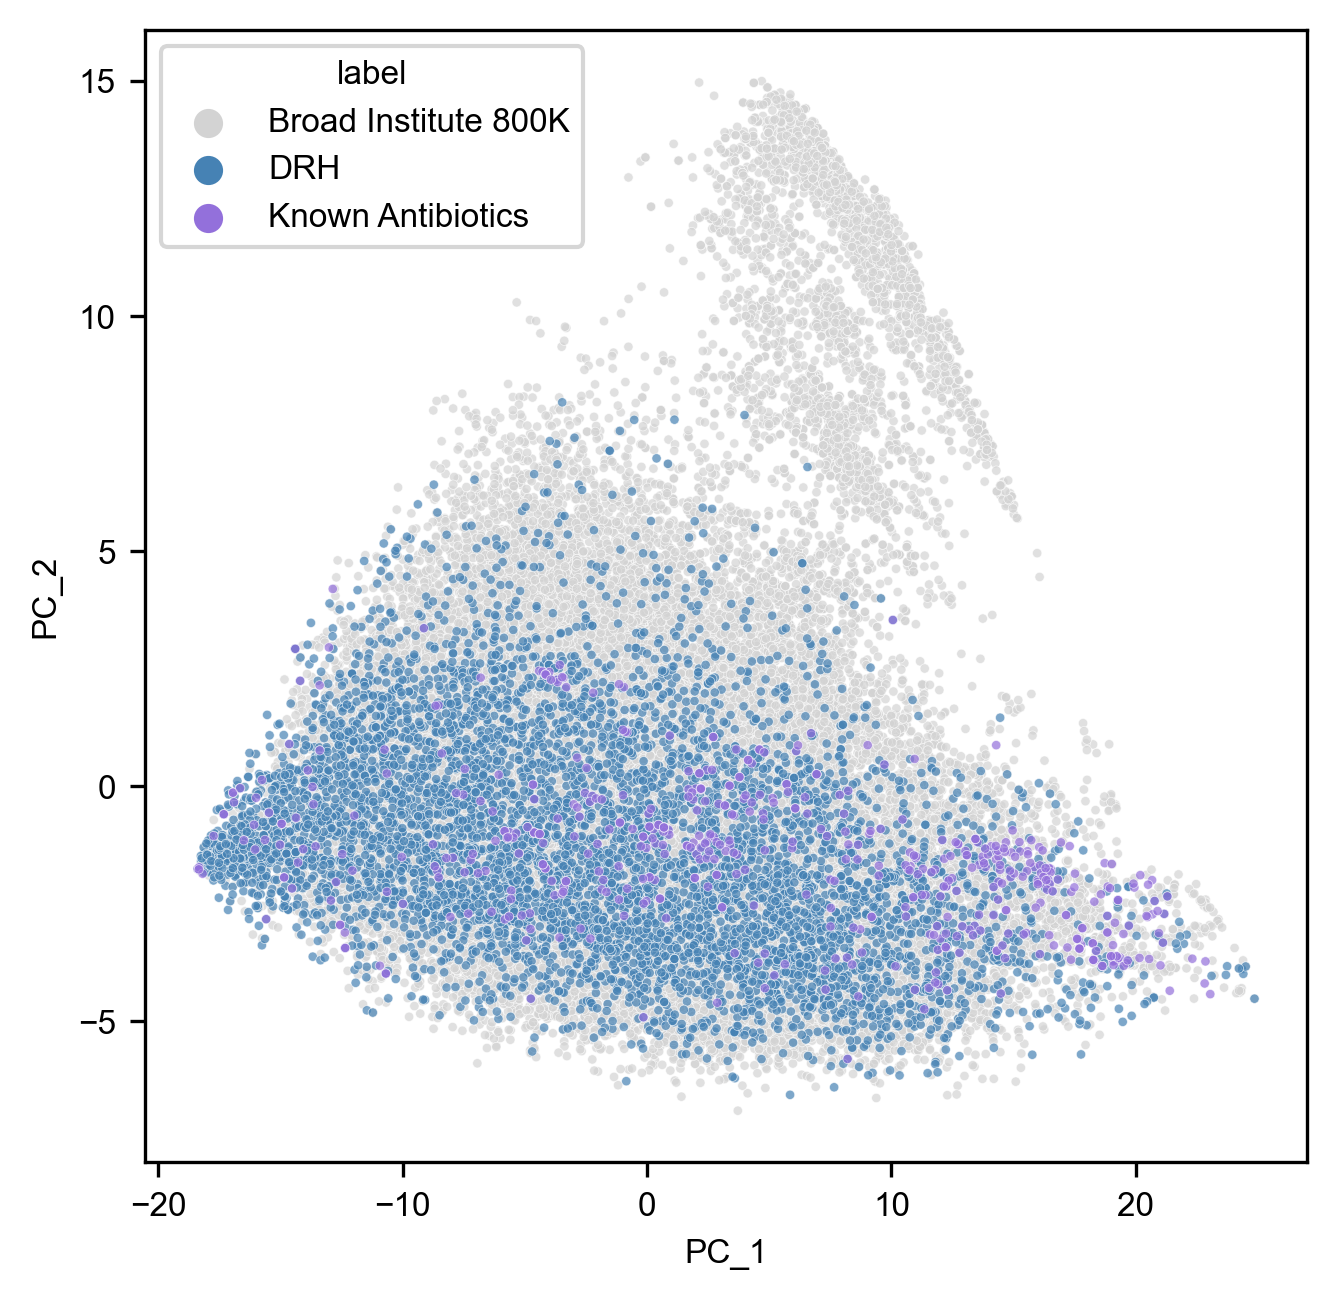

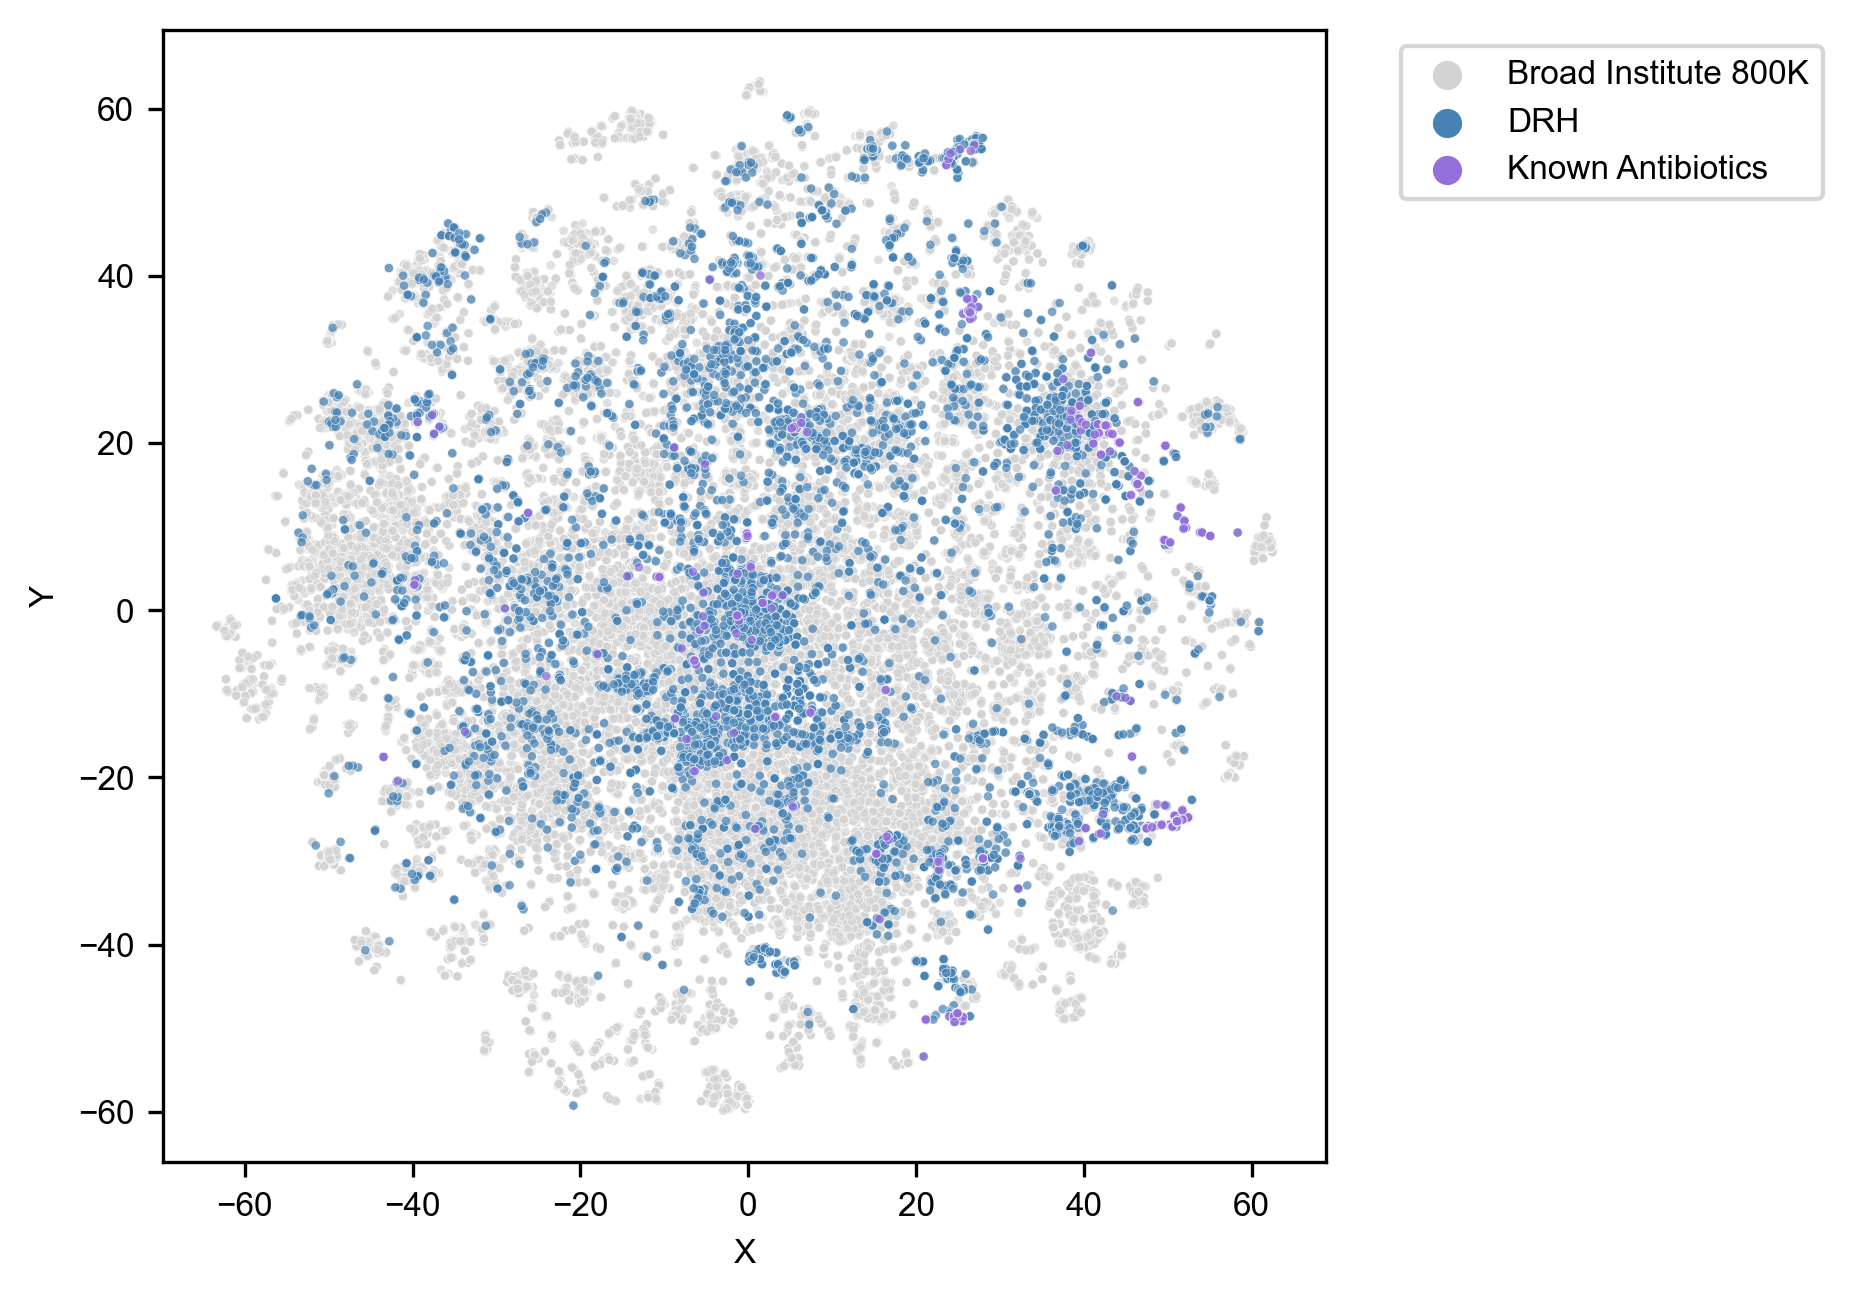

In [4]:
# make a list of fingerprints for t-SNE
fp_list = list(broad_fps)
fp_list.extend(drh_fps)
fp_list.extend(abx_fps)

# make a list of labels for t-SNE
fp_labels = ['Broad Institute 800K'] * len(broad_fps)
fp_labels.extend(['DRH'] * len(drh_fps))
fp_labels.extend(['Known Antibiotics'] * len(abx_fps))

# compute t-SNE
colors_for_vis = ['lightgray','steelblue','mediumpurple']
tsne_df = pca_tsne_mols(fp_list, fp_labels, colors_for_vis, path = '../figure_panels/S2A_drh_vs_broad800k_tsne_data')

# Part 2: Save plot and information

In [5]:
# get names information for metadata
name_list = list(broad_smiles)
name_list.extend(drh_names)
name_list.extend(abx_names)

# get SMILES information for metadata
smis_list = list(broad_smiles)
smis_list.extend(drh_smiles)
smis_list.extend(abx_smiles)

# make a table with this metadata
testdf = tsne_df
testdf['Name'] = name_list
testdf['SMILES'] = smis_list

# add in the SMILES and Class-Annotated for the antibiotics
abx = abx[['Smiles', 'Class-Annotated']]
abx = abx.drop_duplicates('Smiles')
testdf = testdf.merge(abx, left_on = 'SMILES', right_on = 'Smiles', how = 'left')
testdf = testdf.fillna('N/A')

In [6]:
# save the dataframe
testdf.to_csv('../out/drh_vs_broad800k_tsne_data.csv', index = False)
testdf

,X,Y,label,Name,SMILES,Smiles,Class-Annotated
0,-6.543223,-17.317196,Broad Institute 800K,COc1ccc2ccc3ccc(c(c3c2c1)OC(=O)C)OC,COc1ccc2ccc3ccc(c(c3c2c1)OC(=O)C)OC,N/A,N/A
1,20.073427,-14.317855,Broad Institute 800K,Fc1cccc(c1NC(=O)C1CCN(CC1)C(=O)c1cccs1)F,Fc1cccc(c1NC(=O)C1CCN(CC1)C(=O)c1cccs1)F,N/A,N/A
2,-9.944339,34.536869,Broad Institute 800K,CCn1c(nc2ccccc12)-c1nccn1C[C@H]1CCCCO1,CCn1c(nc2ccccc12)-c1nccn1C[C@H]1CCCCO1,N/A,N/A
3,14.058652,18.898560,Broad Institute 800K,CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)N[C@@H](C)Cc1c[n...,CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)N[C@@H](C)Cc1c[n...,N/A,N/A
4,-52.071888,2.526221,Broad Institute 800K,OC(=O)c1sccc1S(=O)(=O)N1CCCCC1,OC(=O)c1sccc1S(=O)(=O)N1CCCCC1,N/A,N/A
...,...,...,...,...,...,...,...
57272,-10.906402,4.011245,Known Antibiotics,NIFUROXAZIDE,O=C(N/N=C/c1ccc([N+](=O)[O-])o1)c1ccc(O)cc1,O=C(N/N=C/c1ccc([N+](=O)[O-])o1)c1ccc(O)cc1,nitrofuran
57273,1.468567,40.045055,Known Antibiotics,NIFURQUINAZOL,O=[N+]([O-])c1ccc(-c2nc(N(CCO)CCO)c3ccccc3n2)o1,O=[N+]([O-])c1ccc(-c2nc(N(CCO)CCO)c3ccccc3n2)o1,nitrofuran
57274,-10.572186,4.003799,Known Antibiotics,NIFURTOINOL,O=C1CN(/N=C/c2ccc([N+](=O)[O-])o2)C(=O)N1CO,O=C1CN(/N=C/c2ccc([N+](=O)[O-])o2)C(=O)N1CO,nitrofuran
57275,-13.020386,5.138186,Known Antibiotics,NIFURZIDE,O=C(N/N=C/C=C/c1ccc([N+](=O)[O-])o1)c1ccc([N+]...,O=C(N/N=C/C=C/c1ccc([N+](=O)[O-])o1)c1ccc([N+]...,nitrofuran
